## Time Series Forecasting for Portfolio Management Optimization for GMF Investments


**Assets Under Analysis**:
- TSLA (Tesla Inc.) - High-risk, high-growth stock
- BND (Vanguard Total Bond Market ETF) - Low-risk bond ETF
- SPY (S&P 500 ETF) - Broad market ETF

**Time Period**: July 1, 2015 – July 31, 2025 (10 years)

### ENVIRONMENT SETUP & LIBRARY IMPORTS

In [4]:
# Install required packages
%pip install yfinance pandas numpy matplotlib seaborn plotly statsmodels scipy -q

In [5]:
# Import necessary libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import warnings
from datetime import datetime, timedelta
from statsmodels.tsa.stattools import adfuller
from scipy import stats

# Configure display settings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print(" Environment setup complete!")
print(" Libraries imported successfully")

 Environment setup complete!
 Libraries imported successfully


## Data Extraction from Yahoo Finance
Extracting 10 years of historical data for our three target assets using the yfinance API.


In [6]:
# Define our assets and time period
ASSETS = ['TSLA', 'BND', 'SPY']
START_DATE = '2015-07-01'
END_DATE = '2025-07-31'

def extract_financial_data(tickers, start_date, end_date):
    """
    Extract financial data for multiple tickers from Yahoo Finance

    Parameters:
    - tickers: List of ticker symbols
    - start_date: Start date (YYYY-MM-DD)
    - end_date: End date (YYYY-MM-DD)

    Returns:
    - Dictionary of DataFrames for each ticker
    """
    data = {}

    for ticker in tickers:
        try:
            print(f" Downloading {ticker} data...")
            stock_data = yf.download(ticker, start=start_date, end=end_date, progress=False)
            data[ticker] = stock_data
            print(f" {ticker}: {len(stock_data)} trading days retrieved")
        except Exception as e:
            print(f" Error downloading {ticker}: {str(e)}")

    return data

# Extract data
raw_data = extract_financial_data(ASSETS, START_DATE, END_DATE)
# Display basic info about extracted data
print("\n Data Extraction Summary:")
for ticker in ASSETS:
    if ticker in raw_data:
        df = raw_data[ticker]
        print(f"{ticker}: {len(df)} days | {df.index.min().date()} to {df.index.max().date()}")


 TSLA: 2535 trading days retrieved
 BND: 2535 trading days retrieved
 SPY: 2535 trading days retrieved

 Data Extraction Summary:
TSLA: 2535 days | 2015-07-01 to 2025-07-30
BND: 2535 days | 2015-07-01 to 2025-07-30
SPY: 2535 days | 2015-07-01 to 2025-07-30



## DATA QUALITY ASSESSMENT

In [7]:
df = raw_data['TSLA']
print(f"Shape: {df.shape}")
missing_values = df.isnull().sum()
print(f"Missing Values:\n{missing_values}")
dublicate_dates = df.index.duplicated().sum()
print(f"Duplicate Dates: {dublicate_dates}")

Shape: (2535, 5)
Missing Values:
Price   Ticker
Close   TSLA      0
High    TSLA      0
Low     TSLA      0
Open    TSLA      0
Volume  TSLA      0
dtype: int64
Duplicate Dates: 0


In [8]:
df = raw_data['BND']
print(f"Shape: {df.shape}")
missing_values = df.isnull().sum()
print(f"Missing Values:\n{missing_values}")
dublicate_dates = df.index.duplicated().sum()
print(f"Duplicate Dates: {dublicate_dates}")

Shape: (2535, 5)
Missing Values:
Price   Ticker
Close   BND       0
High    BND       0
Low     BND       0
Open    BND       0
Volume  BND       0
dtype: int64
Duplicate Dates: 0


In [9]:
df = raw_data['SPY']
print(f"Shape: {df.shape}")
missing_values = df.isnull().sum()
print(f"Missing Values:\n{missing_values}")
dublicate_dates = df.index.duplicated().sum()
print(f"Duplicate Dates: {dublicate_dates}")

Shape: (2535, 5)
Missing Values:
Price   Ticker
Close   SPY       0
High    SPY       0
Low     SPY       0
Open    SPY       0
Volume  SPY       0
dtype: int64
Duplicate Dates: 0


In [10]:
def assess_data_quality(data_dict):
    quality_report = {}
    print(" DATA QUALITY ASSESSMENT")
    for ticker, df in data_dict.items():
        print(f"\n {ticker} Analysis:")
        # Basic info
        print(f"Shape: {df.shape}")
        print(f"Date Range: {df.index.min().date()} to {df.index.max().date()}")
        # Missing values
        missing_values = df.isnull().sum()
        print(f"Missing Values:\n{missing_values}")

        # Data types
        print(f"Data Types:\n{df.dtypes}")

        # Duplicates
        duplicates = df.index.duplicated().sum()
        print(f"Duplicate Dates: {duplicates}")

        # Store in quality report
        quality_report[ticker] = {
            'shape': df.shape,
            'missing_values': missing_values.sum(),
            'duplicates': duplicates,
            'date_range': (df.index.min(), df.index.max())
        }
        # Check for zero or negative prices
        price_columns = ['Open', 'High', 'Low', 'Close', 'Adj Close']
        present_price_columns = [col for col in price_columns if col in df.columns]

        if present_price_columns:
            price_issues = (df[present_price_columns] <= 0).sum()
            if price_issues.sum() > 0:
                print(f"  Zero/Negative Prices:\n{price_issues}")
        else:
            print("  No standard price columns found (Open, High, Low, Close, Adj Close)")
    return quality_report
quality_report = assess_data_quality(raw_data)

 DATA QUALITY ASSESSMENT

 TSLA Analysis:
Shape: (2535, 5)
Date Range: 2015-07-01 to 2025-07-30
Missing Values:
Price   Ticker
Close   TSLA      0
High    TSLA      0
Low     TSLA      0
Open    TSLA      0
Volume  TSLA      0
dtype: int64
Data Types:
Price   Ticker
Close   TSLA      float64
High    TSLA      float64
Low     TSLA      float64
Open    TSLA      float64
Volume  TSLA        int64
dtype: object
Duplicate Dates: 0

 BND Analysis:
Shape: (2535, 5)
Date Range: 2015-07-01 to 2025-07-30
Missing Values:
Price   Ticker
Close   BND       0
High    BND       0
Low     BND       0
Open    BND       0
Volume  BND       0
dtype: int64
Data Types:
Price   Ticker
Close   BND       float64
High    BND       float64
Low     BND       float64
Open    BND       float64
Volume  BND         int64
dtype: object
Duplicate Dates: 0

 SPY Analysis:
Shape: (2535, 5)
Date Range: 2015-07-01 to 2025-07-30
Missing Values:
Price   Ticker
Close   SPY       0
High    SPY       0
Low     SPY       0
Open 


## DATA CLEANING & PREPROCESSING
Handling missing values, outliers, and preparing data for analysis.


In [13]:
clean_data = clean_financial_data(raw_data)

 Cleaning TSLA data...
 TSLA cleaned: 2535 records
 Cleaning BND data...
 BND cleaned: 2535 records
 Cleaning SPY data...
 SPY cleaned: 2535 records


In [12]:
def clean_financial_data(data_dict):
    """
    Clean and preprocess financial data
    """
    cleaned_data = {}

    for ticker, df in data_dict.items():
        print(f" Cleaning {ticker} data...")

        # Create a copy
        clean_df = df.copy()

        # Handle missing values using forward fill then backward fill
        clean_df = clean_df.fillna(method='ffill').fillna(method='bfill')

        # Remove duplicates (keep first occurrence)
        clean_df = clean_df[~clean_df.index.duplicated(keep='first')]

        # Sort by date
        clean_df = clean_df.sort_index()

        # Add 'Adj Close' if not present (using 'Close' as a proxy)
        if 'Adj Close' not in clean_df.columns:
            clean_df['Adj Close'] = clean_df['Close']

        # Add ticker column for identification
        clean_df['Ticker'] = ticker

        cleaned_data[ticker] = clean_df

        print(f" {ticker} cleaned: {len(clean_df)} records")

    return cleaned_data

# Clean the data
clean_data = clean_financial_data(raw_data)

 Cleaning TSLA data...
 TSLA cleaned: 2535 records
 Cleaning BND data...
 BND cleaned: 2535 records
 Cleaning SPY data...
 SPY cleaned: 2535 records



 ## EXPLORATORY DATA ANALYSIS (EDA)
Visualizing price behavior, calculating returns, and understanding volatility patterns.



 TSLA Returns Summary:
Mean Daily Return: 0.0011 (28.62% annualized)
Daily Volatility: 0.0372 (59.02% annualized)
Min Return: -0.2365
Max Return: 0.2045

 BND Returns Summary:
Mean Daily Return: 0.0001 (1.81% annualized)
Daily Volatility: 0.0035 (5.50% annualized)
Min Return: -0.0559
Max Return: 0.0413

 SPY Returns Summary:
Mean Daily Return: 0.0005 (12.81% annualized)
Daily Volatility: 0.0115 (18.28% annualized)
Min Return: -0.1159
Max Return: 0.0999


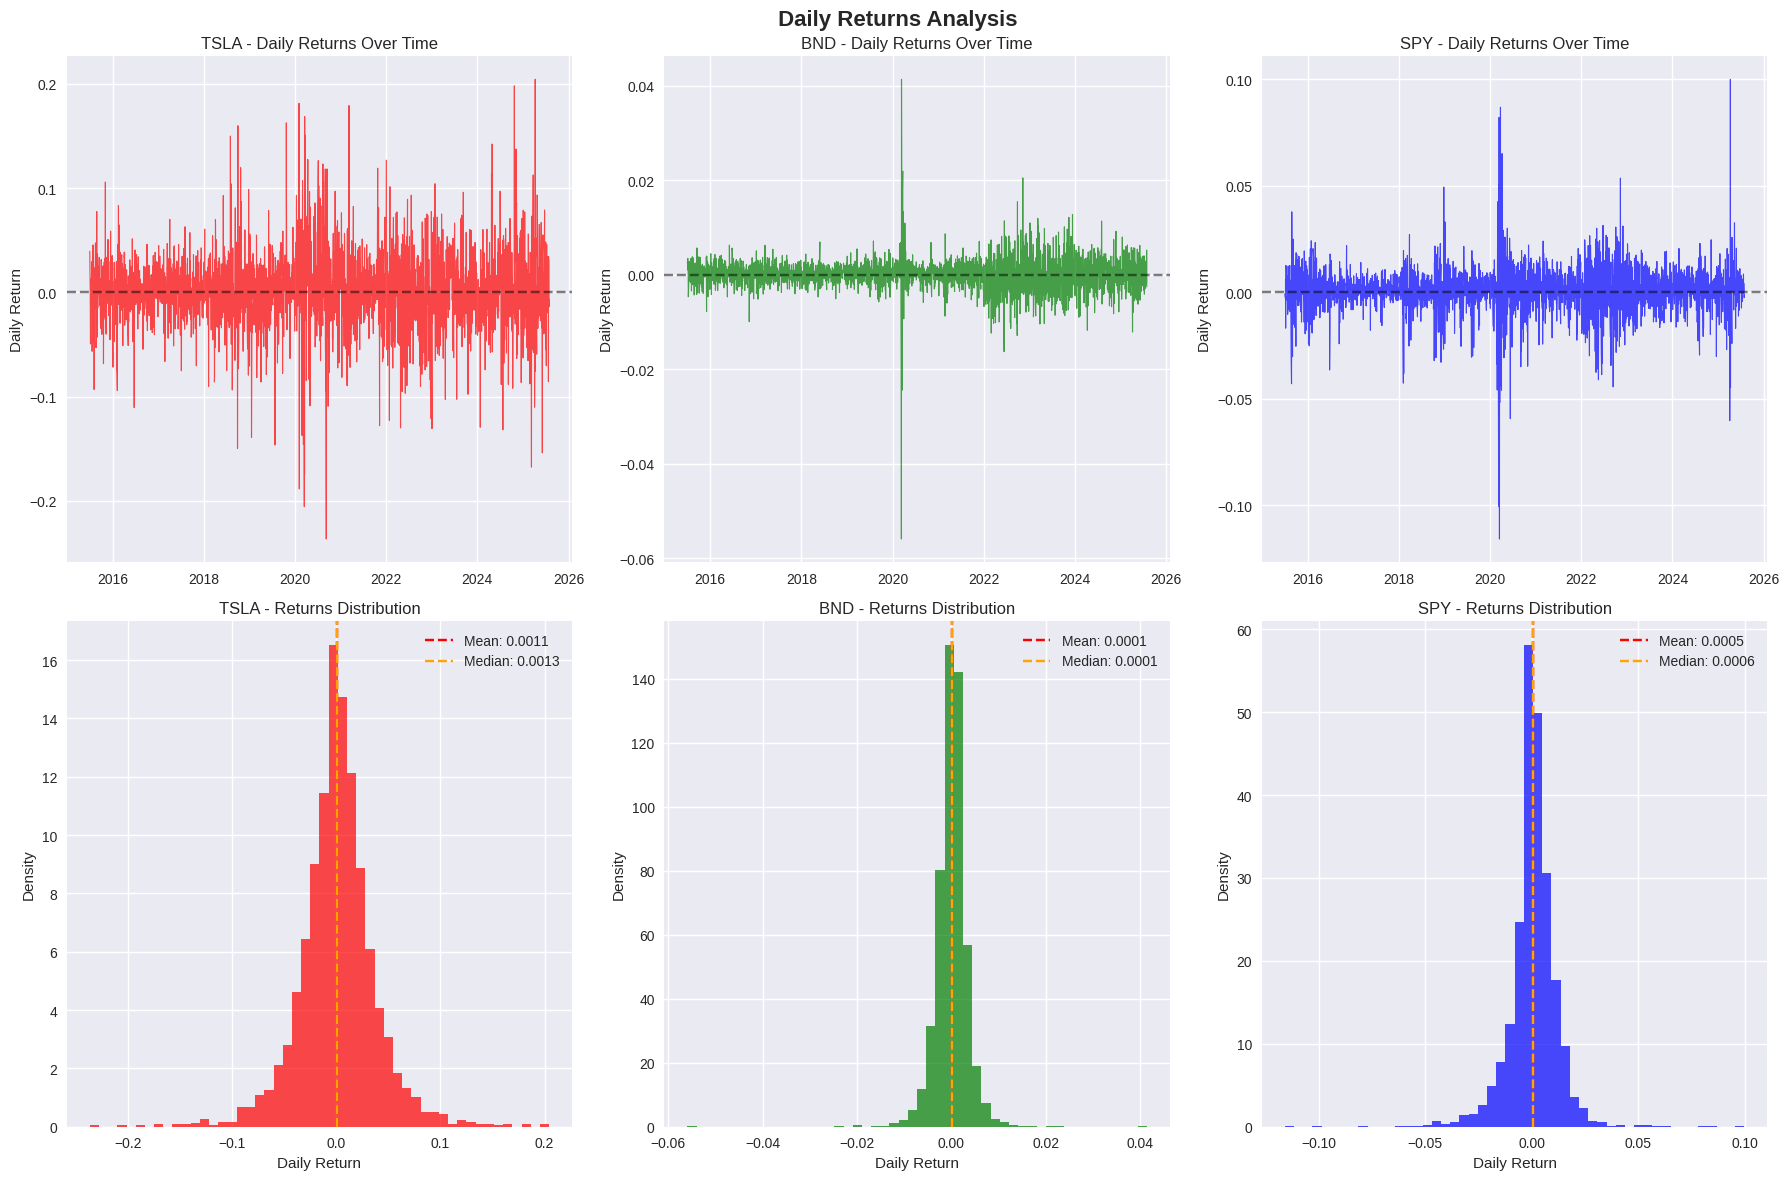

In [14]:
#  Price Visualization
def plot_price_evolution(data_dict):
    """
    Plot closing price evolution for all assets
    """
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=('All Assets - Closing Prices', 'TSLA', 'BND', 'SPY'),
        specs=[[{"colspan": 2}, None],
               [{}, {}]]
    )
    # Combined plot
    for ticker, df in data_dict.items():
        fig.add_trace(
            go.Scatter(x=df.index, y=df['Adj Close'],
                      name=ticker, line=dict(width=2)),
            row=1, col=1
        )
    # Individual plots
    positions = [(2, 1), (2, 2)]
    assets = ['TSLA', 'SPY']  # BND will be handled separately due to scale

    for i, ticker in enumerate(assets):
        if ticker in data_dict:
            df = data_dict[ticker]
            row, col = positions[i]
            fig.add_trace(
                go.Scatter(x=df.index, y=df['Adj Close'],
                          name=ticker, showlegend=False,
                          line=dict(color=['red', 'blue'][i], width=2)),
                row=row, col=col
            )

    fig.update_layout(
        title=" Historical Price Evolution (2015-2025)",
        height=800,
        showlegend=True
    )

    fig.show()

plot_price_evolution(clean_data)

# Calculate Daily Returns
def calculate_returns(data_dict):
    """
    Calculate daily log returns for all assets
    """
    returns_data = {}

    for ticker, df in data_dict.items():
        # Calculate log returns
        log_returns = np.log(df['Adj Close'] / df['Adj Close'].shift(1))

        # Create returns dataframe
        returns_df = pd.DataFrame({
            'Date': df.index,
            'Price': df['Adj Close'],
            'Daily_Return': log_returns,
            'Cumulative_Return': (1 + log_returns).cumprod() - 1,
            'Ticker': ticker
        })

        returns_df.set_index('Date', inplace=True)
        returns_data[ticker] = returns_df.dropna()

        # Print summary statistics
        print(f"\n {ticker} Returns Summary:")

        print(f"Mean Daily Return: {log_returns.mean():.4f} ({log_returns.mean()*252:.2%} annualized)")
        print(f"Daily Volatility: {log_returns.std():.4f} ({log_returns.std()*np.sqrt(252):.2%} annualized)")
        print(f"Min Return: {log_returns.min():.4f}")
        print(f"Max Return: {log_returns.max():.4f}")

    return returns_data

returns_data = calculate_returns(clean_data)

#  Returns Distribution Analysis
def plot_returns_analysis(returns_data):
    """
    Analyze and visualize returns distribution
    """
    # Create subplots for returns analysis
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(' Daily Returns Analysis', fontsize=16, fontweight='bold')

    colors = ['red', 'green', 'blue']

    for i, (ticker, df) in enumerate(returns_data.items()):
        returns = df['Daily_Return'].dropna()

        # Time series plot
        axes[0, i].plot(df.index, returns, color=colors[i], alpha=0.7, linewidth=0.8)
        axes[0, i].set_title(f'{ticker} - Daily Returns Over Time')
        axes[0, i].axhline(y=0, color='black', linestyle='--', alpha=0.5)
        axes[0, i].set_ylabel('Daily Return')

        # Distribution histogram
        axes[1, i].hist(returns, bins=50, color=colors[i], alpha=0.7, density=True)
        axes[1, i].axvline(returns.mean(), color='red', linestyle='--',
                          label=f'Mean: {returns.mean():.4f}')
        axes[1, i].axvline(returns.median(), color='orange', linestyle='--',
                          label=f'Median: {returns.median():.4f}')
        axes[1, i].set_title(f'{ticker} - Returns Distribution')
        axes[1, i].set_xlabel('Daily Return')
        axes[1, i].set_ylabel('Density')
        axes[1, i].legend()

    plt.tight_layout()
    plt.show()

plot_returns_analysis(returns_data)




## VOLATILITY & RISK ANALYSIS
Computing rolling statistics, Value at Risk (VaR), and Sharpe ratios.

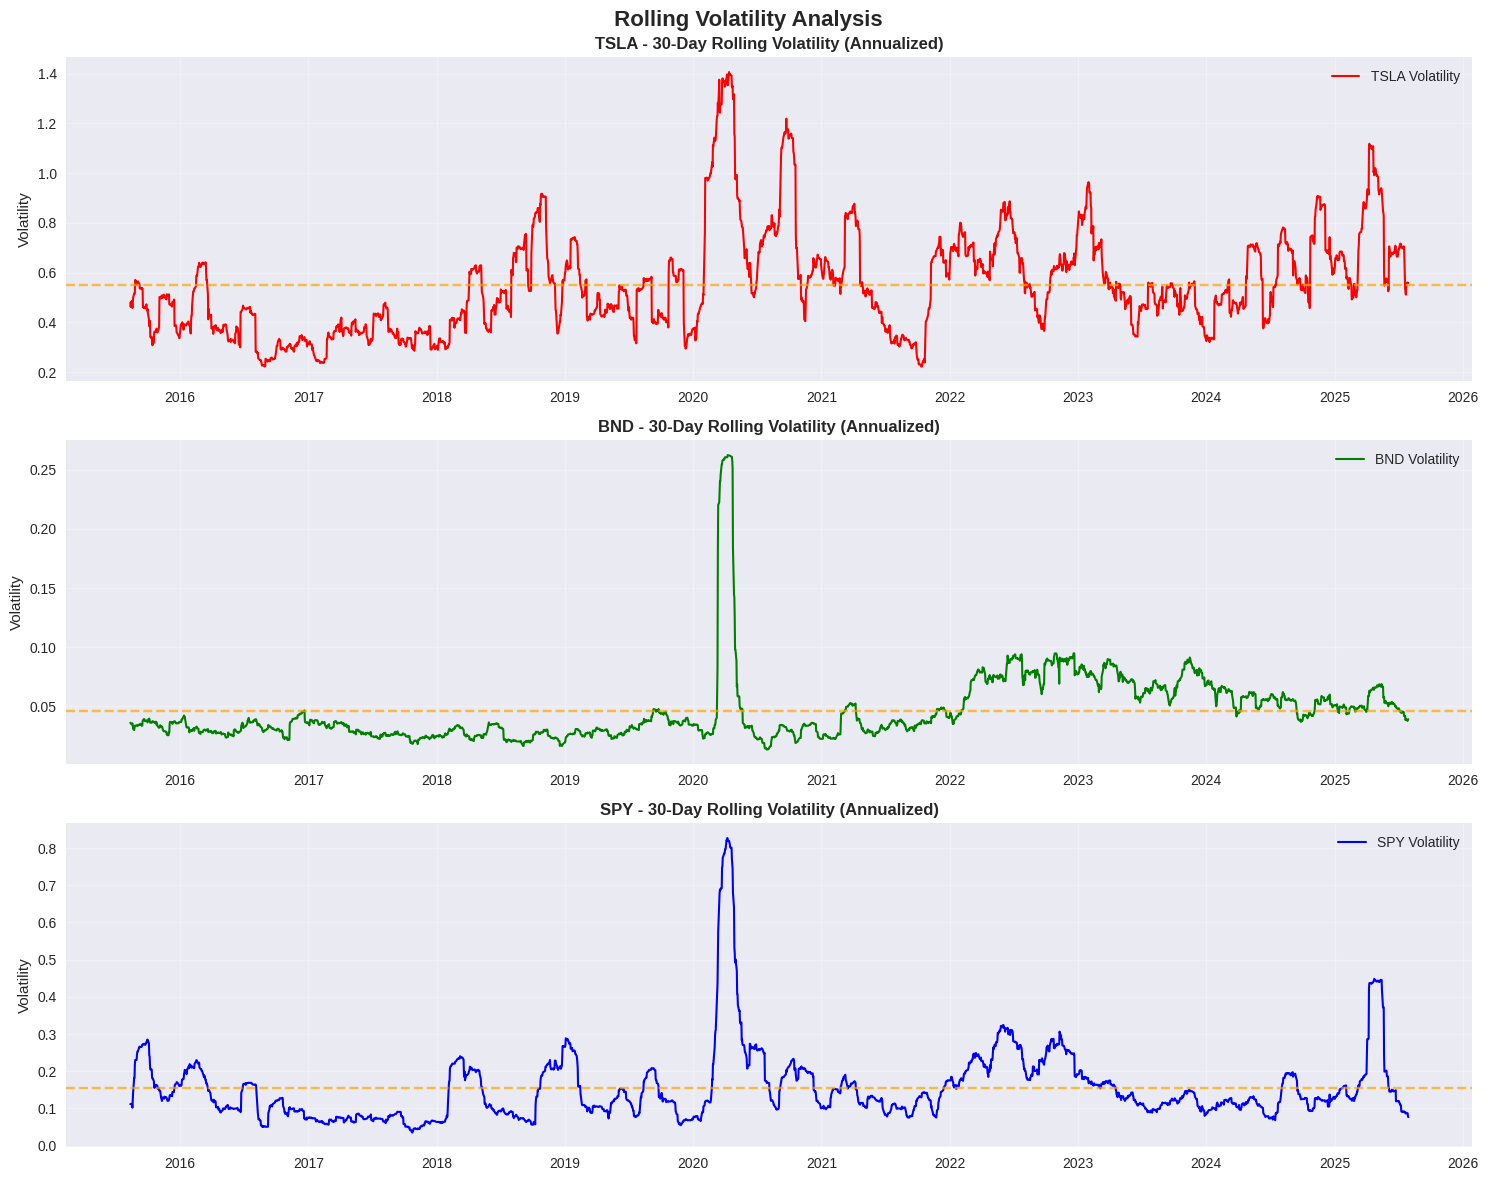

⚡ RISK METRICS ANALYSIS

 TSLA Risk Profile:
Annual Return: 28.62%
Annual Volatility: 59.02%
Sharpe Ratio: 0.451
VaR (95%): -0.0562
VaR (99%): -0.0973
Max Drawdown: -79.88%
Skewness: -0.050
Kurtosis: 4.220

 BND Risk Profile:
Annual Return: 1.81%
Annual Volatility: 5.50%
Sharpe Ratio: -0.035
VaR (95%): -0.0049
VaR (99%): -0.0088
Max Drawdown: -18.85%
Skewness: -1.143
Kurtosis: 38.152

 SPY Risk Profile:
Annual Return: 12.81%
Annual Volatility: 18.28%
Sharpe Ratio: 0.592
VaR (95%): -0.0173
VaR (99%): -0.0337
Max Drawdown: -35.75%
Skewness: -0.583
Kurtosis: 14.270


In [15]:
# Rolling Statistics
def calculate_rolling_stats(returns_data, window=30):
    """
    Calculate rolling volatility and other statistics
    """
    rolling_stats = {}

    for ticker, df in returns_data.items():
        returns = df['Daily_Return']

        rolling_data = pd.DataFrame({
            'Price': df['Price'],
            'Returns': returns,
            'Rolling_Mean': returns.rolling(window=window).mean(),
            'Rolling_Std': returns.rolling(window=window).std(),
            'Rolling_Vol_Annualized': returns.rolling(window=window).std() * np.sqrt(252)
        }, index=df.index)

        rolling_stats[ticker] = rolling_data

    return rolling_stats

rolling_stats = calculate_rolling_stats(returns_data, window=30)

# Plot Rolling Volatility
def plot_rolling_volatility(rolling_stats):
    """
    Plot rolling volatility for all assets
    """
    fig, axes = plt.subplots(3, 1, figsize=(15, 12))
    colors = ['red', 'green', 'blue']

    for i, (ticker, df) in enumerate(rolling_stats.items()):
        axes[i].plot(df.index, df['Rolling_Vol_Annualized'],
                    color=colors[i], linewidth=1.5, label=f'{ticker} Volatility')
        axes[i].set_title(f'{ticker} - 30-Day Rolling Volatility (Annualized)', fontweight='bold')
        axes[i].set_ylabel('Volatility')
        axes[i].grid(True, alpha=0.3)
        axes[i].legend()

        # Add volatility statistics
        mean_vol = df['Rolling_Vol_Annualized'].mean()
        axes[i].axhline(y=mean_vol, color='orange', linestyle='--', alpha=0.7,
                       label=f'Mean: {mean_vol:.2%}')

    plt.suptitle(' Rolling Volatility Analysis', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

plot_rolling_volatility(rolling_stats)

# Risk Metrics Calculation
def calculate_risk_metrics(returns_data, confidence_level=0.05):
    """
    Calculate comprehensive risk metrics
    """
    risk_metrics = {}

    print("⚡ RISK METRICS ANALYSIS")


    for ticker, df in returns_data.items():
        returns = df['Daily_Return'].dropna()

        # Basic statistics
        mean_return = returns.mean() * 252  # Annualized
        volatility = returns.std() * np.sqrt(252)  # Annualized

        # Value at Risk (VaR)
        var_95 = np.percentile(returns, confidence_level * 100)
        var_99 = np.percentile(returns, 1)

        # Conditional VaR (Expected Shortfall)
        cvar_95 = returns[returns <= var_95].mean()

        # Sharpe Ratio (assuming risk-free rate of 2%)
        risk_free_rate = 0.02
        sharpe_ratio = (mean_return - risk_free_rate) / volatility

        # Maximum Drawdown
        cumulative_returns = (1 + returns).cumprod()
        rolling_max = cumulative_returns.expanding().max()
        drawdown = (cumulative_returns - rolling_max) / rolling_max
        max_drawdown = drawdown.min()

        # Skewness and Kurtosis
        skewness = stats.skew(returns.dropna())
        kurtosis = stats.kurtosis(returns.dropna())

        metrics = {
            'Annual_Return': mean_return,
            'Annual_Volatility': volatility,
            'Sharpe_Ratio': sharpe_ratio,
            'VaR_95': var_95,
            'VaR_99': var_99,
            'CVaR_95': cvar_95,
            'Max_Drawdown': max_drawdown,
            'Skewness': skewness,
            'Kurtosis': kurtosis
        }

        risk_metrics[ticker] = metrics

        # Print formatted results
        print(f"\n {ticker} Risk Profile:")

        print(f"Annual Return: {mean_return:.2%}")
        print(f"Annual Volatility: {volatility:.2%}")
        print(f"Sharpe Ratio: {sharpe_ratio:.3f}")
        print(f"VaR (95%): {var_95:.4f}")
        print(f"VaR (99%): {var_99:.4f}")
        print(f"Max Drawdown: {max_drawdown:.2%}")
        print(f"Skewness: {skewness:.3f}")
        print(f"Kurtosis: {kurtosis:.3f}")

    return risk_metrics

risk_metrics = calculate_risk_metrics(returns_data)


## STATIONARITY ANALYSI

Testing for stationarity in prices and returns using the Augmented Dickey-Fuller test.


In [16]:
def test_stationarity(data_dict, returns_data):
    """
    Perform Augmented Dickey-Fuller test for stationarity
    """
    print(" STATIONARITY ANALYSIS")


    stationarity_results = {}

    for ticker in data_dict.keys():
        print(f"\n {ticker} Stationarity Tests:")


        # Test prices
        prices = data_dict[ticker]['Adj Close'].dropna()
        adf_prices = adfuller(prices)

        print(" PRICES:")
        print(f"  ADF Statistic: {adf_prices[0]:.4f}")
        print(f"  p-value: {adf_prices[1]:.4f}")
        print(f"  Critical Values: {adf_prices[4]}")

        if adf_prices[1] <= 0.05:
            print("   Prices are STATIONARY (reject null hypothesis)")
            price_stationary = True
        else:
            print("   Prices are NON-STATIONARY (fail to reject null hypothesis)")
            price_stationary = False

        # Test returns
        returns = returns_data[ticker]['Daily_Return'].dropna()
        adf_returns = adfuller(returns)

        print("\n RETURNS:")
        print(f"  ADF Statistic: {adf_returns[0]:.4f}")
        print(f"  p-value: {adf_returns[1]:.4f}")
        print(f"  Critical Values: {adf_returns[4]}")

        if adf_returns[1] <= 0.05:
            print("   Returns are STATIONARY (reject null hypothesis)")
            returns_stationary = True
        else:
            print("   Returns are NON-STATIONARY (fail to reject null hypothesis)")
            returns_stationary = False

        stationarity_results[ticker] = {
            'prices_stationary': price_stationary,
            'returns_stationary': returns_stationary,
            'price_adf_stat': adf_prices[0],
            'price_p_value': adf_prices[1],
            'returns_adf_stat': adf_returns[0],
            'returns_p_value': adf_returns[1]
        }

    return stationarity_results

stationarity_results = test_stationarity(clean_data, returns_data)


 STATIONARITY ANALYSIS

 TSLA Stationarity Tests:
 PRICES:
  ADF Statistic: -1.4189
  p-value: 0.5732
  Critical Values: {'1%': np.float64(-3.4329610922579095), '5%': np.float64(-2.8626935681060375), '10%': np.float64(-2.567384088736619)}
   Prices are NON-STATIONARY (fail to reject null hypothesis)

 RETURNS:
  ADF Statistic: -11.7171
  p-value: 0.0000
  Critical Values: {'1%': np.float64(-3.4329527780962255), '5%': np.float64(-2.8626898965523724), '10%': np.float64(-2.567382133955709)}
   Returns are STATIONARY (reject null hypothesis)

 BND Stationarity Tests:
 PRICES:
  ADF Statistic: -1.5363
  p-value: 0.5155
  Critical Values: {'1%': np.float64(-3.432946577138947), '5%': np.float64(-2.8626871581881708), '10%': np.float64(-2.5673806760176046)}
   Prices are NON-STATIONARY (fail to reject null hypothesis)

 RETURNS:
  ADF Statistic: -9.9400
  p-value: 0.0000
  Critical Values: {'1%': np.float64(-3.4329579682301254), '5%': np.float64(-2.8626921885291017), '10%': np.float64(-2.567383



# CORRELATION ANALYSIS
Understanding relationships between our three assets.


 CORRELATION ANALYSIS
Correlation Matrix (Daily Returns):
        TSLA     BND     SPY
TSLA  1.0000  0.0598  0.4949
BND   0.0598  1.0000  0.1163
SPY   0.4949  0.1163  1.0000


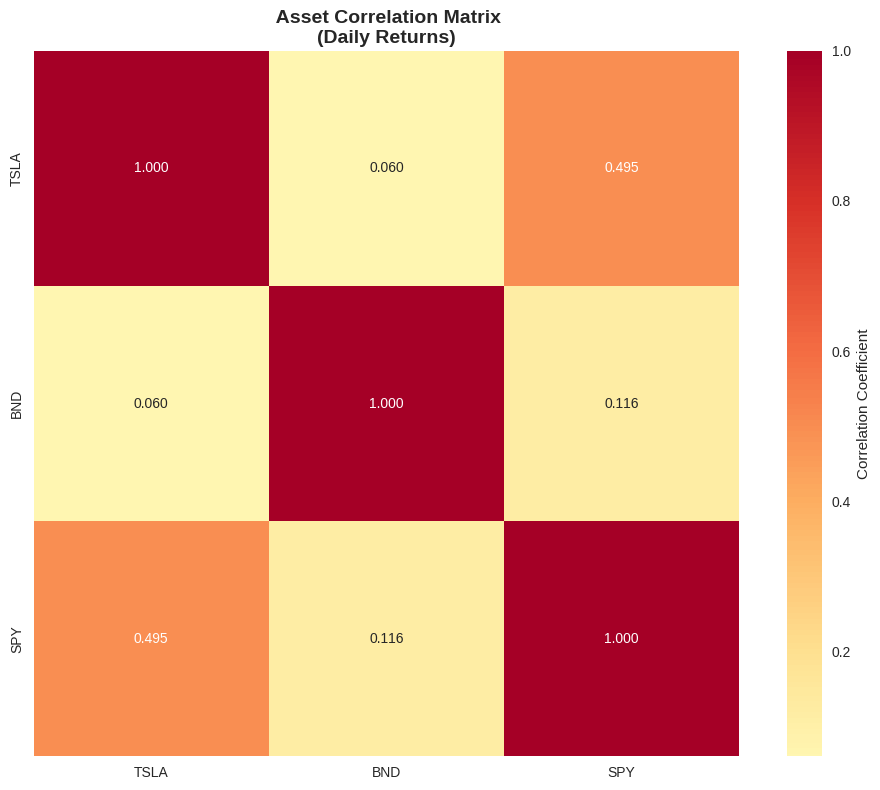

In [17]:
def correlation_analysis(returns_data):
    """
    Perform correlation analysis between assets
    """
    # Combine all returns into one DataFrame
    combined_returns = pd.DataFrame()

    for ticker, df in returns_data.items():
        combined_returns[ticker] = df['Daily_Return']

    # Calculate correlation matrix
    correlation_matrix = combined_returns.corr()

    print(" CORRELATION ANALYSIS")

    print("Correlation Matrix (Daily Returns):")
    print(correlation_matrix.round(4))

    # Plot correlation heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='RdYlBu_r', center=0,
                square=True, fmt='.3f', cbar_kws={'label': 'Correlation Coefficient'})
    plt.title(' Asset Correlation Matrix\n(Daily Returns)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    return correlation_matrix, combined_returns

correlation_matrix, combined_returns = correlation_analysis(returns_data)




## SUMMARY STATISTICS & INSIGHTS
Comprehensive overview of our data analysis findings.


In [19]:
def generate_summary_report(clean_data, risk_metrics, stationarity_results, correlation_matrix):
    """
    Generate a comprehensive summary report
    """
    print(" COMPREHENSIVE SUMMARY REPORT")


    # Data Overview
    print("\n DATA OVERVIEW:")

    total_days = 0
    for ticker, df in clean_data.items():
        days = len(df)
        total_days += days
        print(f"{ticker}: {days:,} trading days")
    print(f"Total data points: {total_days:,}")

    # Risk-Return Profile
    print("\n RISK-RETURN PROFILE:")

    print(f"{'Asset':<6} {'Return':<8} {'Risk':<8} {'Sharpe':<8} {'Max DD':<8}")


    for ticker, metrics in risk_metrics.items():
        print(f"{ticker:<6} {metrics['Annual_Return']:<8.2%} "
              f"{metrics['Annual_Volatility']:<8.2%} "
              f"{metrics['Sharpe_Ratio']:<8.3f} "
              f"{metrics['Max_Drawdown']:<8.2%}")

    # Stationarity Summary
    print("\n STATIONARITY SUMMARY:")

    for ticker, results in stationarity_results.items():
        price_status = " Stationary" if results['prices_stationary'] else " Non-stationary"
        return_status = " Stationary" if results['returns_stationary'] else " Non-stationary"
        print(f"{ticker} - Prices: {price_status}, Returns: {return_status}")

    # Correlation Insights
    print("\n CORRELATION INSIGHTS:")

    print("Key correlations:")
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            asset1 = correlation_matrix.columns[i]
            asset2 = correlation_matrix.columns[j]
            corr = correlation_matrix.loc[asset1, asset2]
            print(f"{asset1}-{asset2}: {corr:.3f}")

    # Key Insights
    print("\n KEY INSIGHTS:")


    # Find highest/lowest performers
    best_return = max(risk_metrics.items(), key=lambda x: x[1]['Annual_Return'])
    worst_return = min(risk_metrics.items(), key=lambda x: x[1]['Annual_Return'])
    lowest_risk = min(risk_metrics.items(), key=lambda x: x[1]['Annual_Volatility'])
    highest_risk = max(risk_metrics.items(), key=lambda x: x[1]['Annual_Volatility'])
    best_sharpe = max(risk_metrics.items(), key=lambda x: x[1]['Sharpe_Ratio'])

    print(f"• Highest Return: {best_return[0]} ({best_return[1]['Annual_Return']:.2%})")
    print(f"• Lowest Return: {worst_return[0]} ({worst_return[1]['Annual_Return']:.2%})")
    print(f"• Lowest Risk: {lowest_risk[0]} ({lowest_risk[1]['Annual_Volatility']:.2%})")
    print(f"• Highest Risk: {highest_risk[0]} ({highest_risk[1]['Annual_Volatility']:.2%})")
    print(f"• Best Risk-Adjusted Return: {best_sharpe[0]} (Sharpe: {best_sharpe[1]['Sharpe_Ratio']:.3f})")

    # Portfolio implications
    print(f"\n PORTFOLIO IMPLICATIONS:")

    print("• All price series are non-stationary (expected for financial assets)")
    print("• All return series are stationary (good for time series modeling)")
    print("• TSLA shows highest volatility - suitable for growth allocation")
    print("• BND shows lowest volatility - suitable for stability/income")
    print("• SPY provides balanced risk-return profile")

    diversification_potential = 1 - correlation_matrix.mean().mean()
    print(f"Diversification potential: {diversification_potential:.2%}")

# Generate the final summary report
generate_summary_report(clean_data, risk_metrics, stationarity_results, correlation_matrix)


 COMPREHENSIVE SUMMARY REPORT

 DATA OVERVIEW:
TSLA: 2,535 trading days
BND: 2,535 trading days
SPY: 2,535 trading days
Total data points: 7,605

 RISK-RETURN PROFILE:
Asset  Return   Risk     Sharpe   Max DD  
TSLA   28.62%   59.02%   0.451    -79.88% 
BND    1.81%    5.50%    -0.035   -18.85% 
SPY    12.81%   18.28%   0.592    -35.75% 

 STATIONARITY SUMMARY:
TSLA - Prices:  Non-stationary, Returns:  Stationary
BND - Prices:  Non-stationary, Returns:  Stationary
SPY - Prices:  Non-stationary, Returns:  Stationary

 CORRELATION INSIGHTS:
Key correlations:
TSLA-BND: 0.060
TSLA-SPY: 0.495
BND-SPY: 0.116

 KEY INSIGHTS:
• Highest Return: TSLA (28.62%)
• Lowest Return: BND (1.81%)
• Lowest Risk: BND (5.50%)
• Highest Risk: TSLA (59.02%)
• Best Risk-Adjusted Return: SPY (Sharpe: 0.592)

 PORTFOLIO IMPLICATIONS:
• All price series are non-stationary (expected for financial assets)
• All return series are stationary (good for time series modeling)
• TSLA shows highest volatility - suitable f


### DATA EXPORT FOR NEXT TASKS
Preparing cleaned data for subsequent tasks (Task 2-5).


In [20]:
# Save cleaned data and analysis results
print("\n EXPORTING DATA FOR NEXT TASKS")

# Create a consolidated dataset
consolidated_data = pd.DataFrame()

for ticker in ASSETS:
    if ticker in clean_data and ticker in returns_data:
        df = clean_data[ticker].copy()
        df['Daily_Return'] = returns_data[ticker]['Daily_Return']
        df['Ticker'] = ticker
        consolidated_data = pd.concat([consolidated_data, df])

print(f" Consolidated dataset created: {len(consolidated_data)} records")

# Export to CSV (commented out for Colab, but ready for local use)
# consolidated_data.to_csv('gmf_financial_data_cleaned.csv')
# pd.DataFrame(risk_metrics).T.to_csv('gmf_risk_metrics.csv')

print("\n TASK 1 COMPLETION STATUS:")

print(" Data extraction from Yahoo Finance - COMPLETE")
print(" Data quality assessment - COMPLETE")
print(" Data cleaning and preprocessing - COMPLETE")
print(" Exploratory data analysis - COMPLETE")
print(" Returns calculation and analysis - COMPLETE")
print(" Volatility and risk metrics - COMPLETE")
print(" Stationarity testing - COMPLETE")
print(" Correlation analysis - COMPLETE")
print(" Summary insights generation - COMPLETE")

print(f"\n Ready for Task 2: Time Series Forecasting Models")
print(f" Dataset prepared with {len(consolidated_data)} observations across {len(ASSETS)} assets")

"""
##  Next Steps (Task 2 Preview)

**Upcoming in Task 2:**
1. **ARIMA/SARIMA Models**: Statistical forecasting for TSLA
2. **LSTM Neural Networks**: Deep learning approach for price prediction
3. **Model Comparison**: Evaluate forecasting accuracy using MAE, RMSE, MAPE
4. **Forecast Visualization**: Plot predictions with confidence intervals

**Key Findings to Carry Forward:**
- TSLA shows highest volatility (suitable for active forecasting)
- Returns are stationary (good for ARIMA modeling)
- Price trends show strong momentum patterns
- Correlation insights will inform portfolio construction
"""


 EXPORTING DATA FOR NEXT TASKS
 Consolidated dataset created: 7605 records

 TASK 1 COMPLETION STATUS:
 Data extraction from Yahoo Finance - COMPLETE
 Data quality assessment - COMPLETE
 Data cleaning and preprocessing - COMPLETE
 Exploratory data analysis - COMPLETE
 Returns calculation and analysis - COMPLETE
 Volatility and risk metrics - COMPLETE
 Stationarity testing - COMPLETE
 Correlation analysis - COMPLETE
 Summary insights generation - COMPLETE

 Ready for Task 2: Time Series Forecasting Models
 Dataset prepared with 7605 observations across 3 assets


'\n##  Next Steps (Task 2 Preview)\n\n**Upcoming in Task 2:**\n1. **ARIMA/SARIMA Models**: Statistical forecasting for TSLA\n2. **LSTM Neural Networks**: Deep learning approach for price prediction\n3. **Model Comparison**: Evaluate forecasting accuracy using MAE, RMSE, MAPE\n4. **Forecast Visualization**: Plot predictions with confidence intervals\n\n**Key Findings to Carry Forward:**\n- TSLA shows highest volatility (suitable for active forecasting)\n- Returns are stationary (good for ARIMA modeling)\n- Price trends show strong momentum patterns\n- Correlation insights will inform portfolio construction\n'

In [21]:
# Save consolidated data to Excel
try:
    consolidated_data.to_excel('gmf_financial_data_cleaned.xlsx', index=True)
    print("\n Consolidated data successfully saved to 'gmf_financial_data_cleaned.xlsx'")
except Exception as e:
    print(f"\n Error saving consolidated data to Excel: {e}")


 Consolidated data successfully saved to 'gmf_financial_data_cleaned.xlsx'
